# 1. Import all require packages

In [14]:
import tensorflow as tf

# Hide GPU from visible devices for tensorflow 2.3.1 and above
tf.config.set_visible_devices([], 'GPU')

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils

from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. Read images from the data path

In [15]:
#Define Datapath
data_path = 'jaffe/'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(128,128))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-ANGRY

Loaded the images of dataset-DISGUST

Loaded the images of dataset-FEAR

Loaded the images of dataset-HAPPY

Loaded the images of dataset-NEUTRAL

Loaded the images of dataset-SAD

Loaded the images of dataset-SURPRISE



(213, 128, 128, 3)

# 3. Define the number of classes

In [16]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:59]=1 #29
labels[60:92]=2 #32
labels[93:124]=3 #31
labels[125:155]=4 #30
labels[156:187]=5 #31
labels[188:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

# 4.Convert the class label to one-hot encoding

In [17]:
# convert class labels to on-hot encoding# conve 
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

# 5. CNN Layer Set

In [18]:
# Defining the model

input_shape=img_data[0].shape

model = tf.keras.Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


#2nd CNN layer
model.add(Conv2D(128,(5,5),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Fully connected layer 2nd layer
# model.add(Dense(512))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

#Output layer
model.add(Dense(num_classes,activation="softmax"))

#Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

# 6.View Model Configuration

In [19]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)      

True

In [20]:
from keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
# filename='model_train_new.csv'
# filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

# csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 20),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]
# callbacks_list = [csv_log,checkpoint]
# callbacks_list = [csv_log]

# 7. Train Model

In [21]:
# Training
hist = model.fit(X_train, y_train, batch_size=7, epochs=200, verbose=1, validation_data=(X_test, y_test),callbacks=[checkpointer])

Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 2.3326 - accuracy: 0.1878
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to model.weights.best.hdf5
26/26 [==============================] - 18s 653ms/step - loss: 2.3326 - accuracy: 0.1878 - val_loss: 2.3241 - val_accuracy: 0.0938
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 1.9502 - accuracy: 0.3039
Epoch 2: val_accuracy did not improve from 0.09375
26/26 [==============================] - 20s 791ms/step - loss: 1.9502 - accuracy: 0.3039 - val_loss: 2.0947 - val_accuracy: 0.0938
Epoch 3/200
26/26 [==============================] - ETA: 0s - loss: 1.6230 - accuracy: 0.3481
Epoch 3: val_accuracy did not improve from 0.09375
26/26 [==============================] - 20s 788ms/step - loss: 1.6230 - accuracy: 0.3481 - val_loss: 2.4906 - val_accuracy: 0.0938
Epoch 4/200
26/26 [==============================] - ETA: 0s - loss: 1.4899 - accuracy: 0.4586
Epoch 4: val_accuracy did not

26/26 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9613
Epoch 29: val_accuracy did not improve from 0.81250
26/26 [==============================] - 21s 804ms/step - loss: 0.1379 - accuracy: 0.9613 - val_loss: 0.8787 - val_accuracy: 0.8125
Epoch 30/200
26/26 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9171
Epoch 30: val_accuracy did not improve from 0.81250
26/26 [==============================] - 20s 782ms/step - loss: 0.2022 - accuracy: 0.9171 - val_loss: 0.6881 - val_accuracy: 0.8125
Epoch 31/200
26/26 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9337
Epoch 31: val_accuracy did not improve from 0.81250
26/26 [==============================] - 20s 782ms/step - loss: 0.2062 - accuracy: 0.9337 - val_loss: 1.3077 - val_accuracy: 0.7188
Epoch 32/200
26/26 [==============================] - ETA: 0s - loss: 0.1498 - accuracy: 0.9669
Epoch 32: val_accuracy improved from 0.81250 to 0.87500, saving model to mode

Epoch 57: early stopping


In [22]:
#Model Save
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

<Figure size 432x288 with 0 Axes>

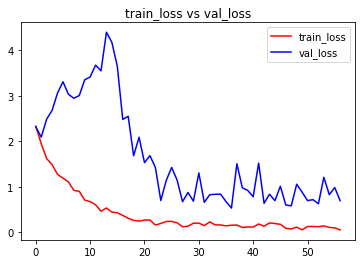

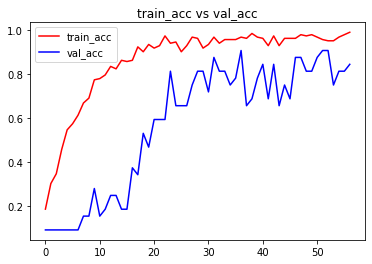

<Figure size 432x288 with 0 Axes>

In [23]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

Test Loss: 0.5359998345375061
Test accuracy: 0.90625
(1, 128, 128, 3)
1/1 [==============================] - 0s 219ms/step
[[4.6180686e-04 1.0397152e-04 6.4159755e-04 6.5175225e-03 9.8262310e-01
  9.5724389e-03 7.9645542e-05]]
[4]
[[0. 0. 0. 0. 1. 0. 0.]]
1/1 [==============================] - 0s 209ms/step


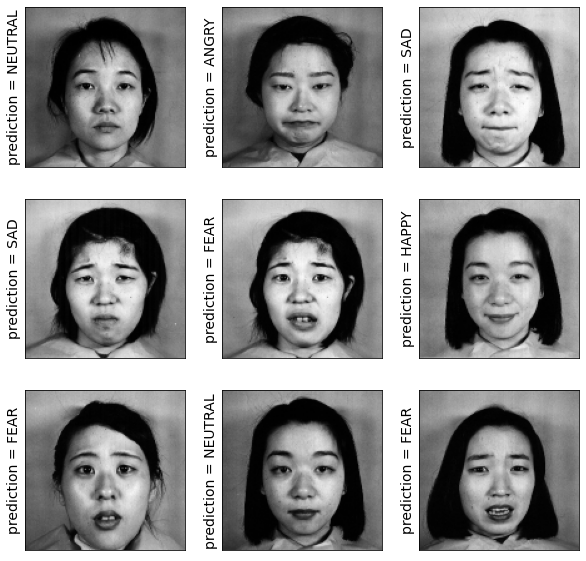

In [24]:
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

predict_x=model.predict(test_image)
print(predict_x)
# print(model.predict_classes(test_image))
print(np.argmax(predict_x,axis=1))
print(y_test[0:1])

# res = model.predict_classes(X_test[:9])
res = np.argmax(model.predict(X_test[:9]), axis=1)
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
# show the plot
plt.show()

1/1 [==============================] - 1s 602ms/step


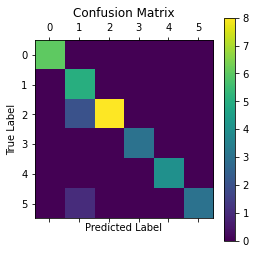

In [25]:
from sklearn.metrics import confusion_matrix
results = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

test image original shape (128, 128, 3)
image original shaape (128, 128, 3)
1/1 [==============================] - 0s 37ms/step


Text(0.5, 0, 'prediction = HAPPY')

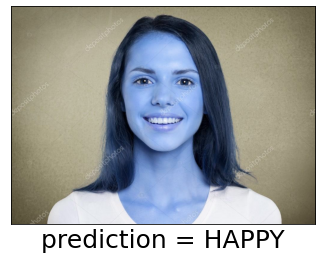

In [26]:
testimg_data_list=[]
test_img=cv2.imread('happy.jpg', 1)

test_img_resize=cv2.resize(test_img,(128,128))
testimg_data_list.append(test_img_resize)
testimg_data = np.array(testimg_data_list)
testimg_data = testimg_data.astype('float32')
testimg_data = testimg_data/255
testimg_data.shape

print("test image original shape",testimg_data[0].shape)
print("image original shaape",img_data[0].shape)

results = np.argmax(model.predict(testimg_data), axis=1)
plt.imshow(test_img,cmap=plt.get_cmap('Set2'))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction = %s' % getLabel(results[0]), fontsize=25)